4G5 Coursework Computer Project: rubber elasticity
====

<!--<img src="./isoprene.png" height=200>-->
<img src="./polyisoprene.png" height=200>

In this project, you are going to investigate the elastic properties of rubber. There are many different types of rubber, both synthetic and
natural, the latter mostly derived from the fluids of the [rubber tree](https://en.wikipedia.org/wiki/Hevea_brasiliensis). All of them have a
common structure: extremely long chains of flexible polymers. Different materials vary in the composition of the polymers, whether and how
cross-linked they are. In this project, we are going to consider the polyisoprene molecule, which is the major constitutent of 
natural rubber. Isoprene is a simple hydrocarbon, a naturally very abundant molecule, even humans produce some! To keep things simple, you
will study only a single polymer chain, and to keep the computational effort low, only a short one. This is already sufficient to display
the main phenomenology of elasticity. 

The main objective of the project is to demonstrate the linear restoring force as a function of displacement for the polyisoprene molecule. 
This will be accomplished by _constrained_ molecular dynamics at constant temperature, in which the two ends of the molecule will be kept at a 
given distance apart, and the molecular motion simulated as it explores the allowable conformations. After sufficient 
data is accumulated, the average force on the end points is recorded, and a new, larger distance is set, repeating the previous procedure. You will
need to use error analysis to determine how long a simulation to do at a fixed displacement before moving on to the next one. 

__Your report__ should contain the measured average restoring force as a function of displacement, with appropriate error bars, and brief commentary on what
you have found. Also consider the average internal energy of molecule (also as a function of displacement), and comment on its relationship to the 
restoring force. 

Notes: 

- If you find that you are spending more than 6 hours on the coursework, seek help. This does _not_ include the runtime of the simulation that you use to gather 
your final data (after you've done shorter exploratory work), it is recommended that you run it overnight. Always make an estimate on how
long a given run will take, never start a simulation for which you have no idea when it will finish!
- Don't forget that the coursework is marked anonymously, so make sure that you include a [coursework cover sheet](http://teaching.eng.cam.ac.uk/node/4171) as the
first page of your report that you upload to Moodle. 
- The marking will be focused on your understanding of the modelling and data analysis, rather than on programming. If you are stuck, seek help.


Preliminaries
----

In [42]:
# Pre - Preliminaries
#!pip install numpy # who hasn't got numpy installed?
!pip install ase
!pip install torchani

In [67]:
#
# import basic atomistic simulation modules
#
import numpy as np
import ase
from ase.build import bulk
from ase.data.pubchem import pubchem_atoms_search
from ase.visualize import view
import matplotlib.pyplot as plt
import pandas as pd 
from statsmodels.tsa.stattools import acf


In [68]:
# get the structure of isoprene
isoprene = pubchem_atoms_search(smiles="CC=C(C)C")
view(isoprene, viewer='x3d')

In [73]:
# import an energy model 
import sys
sys.path.insert(0, "ANI")
import ani

In [72]:
isoprene.calc = ani.calculator
isoprene.get_potential_energy()

-5346.541799350911

In [74]:
#
# now import the modules we need to run molecular dynamics
#
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units
from ase.md.langevin import Langevin
from ase.io.trajectory import Trajectory


In [75]:
# this initialises the velocities by drawing from the appropriate distribution at T=300K
MaxwellBoltzmannDistribution(isoprene, temperature_K=300) 

# We now create a molecular dynamics object that can be used to run Langevin dynamics
# the parameters after the structure are the time step, the temperature, and the friction constant (in units of picoseconds)
dynamics = Langevin(isoprene, temperature_K=300, timestep=0.5*units.fs, friction=0.01) 


# While the dynamics is running, we want to collect some data! This is achieved by creating a function to the dynamics object
# which gets called after some number of steps, and it can report to us what is happenning to the molecule, record its trajectory, etc. 
xyzfile = open('isoprene.xyz', 'w') # the file we are going to record the structures to, the visualiser application "Ovito" can read such XYZ files. 
def report():
    print("Time: {:.3f} fs  |  Potential Energy: {:.3f} eV  |  Kinetic Energy: {:.3f} K".format(dynamics.get_time()/units.fs, isoprene.get_potential_energy(),
        isoprene.get_kinetic_energy()/(len(isoprene)*(3.0/2.0)*units.kB)))
    ase.io.write(xyzfile, isoprene, format="extxyz")

# notice how we print the kinetic energy in units of Kelvin, but it is not the thermodynamic temperature (which is kept constant)

dynamics.attach(report, interval=1) # the interval argument specifies how many steps of dynamics are run between each call to record the trajectory
dynamics.run(100)
xyzfile.close()
del dynamics

# After execution, you will see a new file called "isoprene.xyz". You can look at it, and see what it records. Download it, and view the molecular
# motion using the "Ovito" application. 

Time: 0.000 fs  |  Potential Energy: -5346.542 eV  |  Kinetic Energy: 269.687 K
Time: 0.500 fs  |  Potential Energy: -5346.523 eV  |  Kinetic Energy: 263.583 K
Time: 1.000 fs  |  Potential Energy: -5346.488 eV  |  Kinetic Energy: 243.570 K
Time: 1.500 fs  |  Potential Energy: -5346.447 eV  |  Kinetic Energy: 222.064 K
Time: 2.000 fs  |  Potential Energy: -5346.412 eV  |  Kinetic Energy: 204.973 K
Time: 2.500 fs  |  Potential Energy: -5346.393 eV  |  Kinetic Energy: 193.799 K
Time: 3.000 fs  |  Potential Energy: -5346.392 eV  |  Kinetic Energy: 192.747 K
Time: 3.500 fs  |  Potential Energy: -5346.404 eV  |  Kinetic Energy: 199.749 K
Time: 4.000 fs  |  Potential Energy: -5346.420 eV  |  Kinetic Energy: 208.726 K
Time: 4.500 fs  |  Potential Energy: -5346.428 eV  |  Kinetic Energy: 213.947 K
Time: 5.000 fs  |  Potential Energy: -5346.423 eV  |  Kinetic Energy: 213.604 K
Time: 5.500 fs  |  Potential Energy: -5346.404 eV  |  Kinetic Energy: 203.944 K
Time: 6.000 fs  |  Potential Energy: -53

In [76]:
# Ovito also helps you to select atoms by dragging the "Particles/GLobal Attributes" tab upwards a bit,
# and selecting the little target crosshairs on the left, then clicking on individual atoms. The "ParticleIndex" variable tells you the order
# of the atoms in the file and the ASE atoms object. 

# For example, particle indices 8 and 13 correspond to two H atoms on opposite ends of the isoprene molecule, and we can get their distance:
dr = (isoprene.get_positions()[8,:]-isoprene.get_positions()[13,:])
print("relative displacement vector:", dr)
r = np.linalg.norm(dr)
print("distance: ", r)
dru = dr/np.linalg.norm(dr)
print("unit vector in the same direction:", dru)

relative displacement vector: [ 5.41541042 -0.41902781 -1.04179602]
distance:  5.530605140504469
unit vector in the same direction: [ 0.97917141 -0.07576527 -0.18836926]


Exercise 1 : dynamics and autocorrelation
----

Run molecular dynamics of isoprene, and record the distance between atoms 8 and 13 (two hydrogens) every 10 steps. Plot the time evolution
of this distance, and calculate the autocorrelation function. Run the trajectory long enough that you sample the methyl groups rotating around
the C-C bond. Repeat the exercise at higher temperature (e.g. 500 K), what happens to the autocorrelation function ? 

Note: you can calculate the autocorrelation yourself, or learn to use the `acf` function in  `statsmodels.tsa.stattools`

In [80]:
# --------------------------------- Initial Notes ---------------------------------
'''

We need to:
1. run molecular dynamics of isoprene
2. record the distance between atoms 8 and 13 every 10 steps 
3. plot the time evolution of this distance
4. calculate the autocorrelation function (on what)

Initial Notes

We have the code which currently:
- initialises velocity of molecules and particles
- creates the molecular dynamics object
- have a 'report' function which gets called after a certain number of steps to report
- dynamics.run(100): runs 100 steps of our molecular simulation
- dynamics.attach(report, interval = n): reports every n steps of our simulation
- .get_positions()[k,:] gets the position (in 3-dimensions) of our atoms in our molecules

- we need to investigate the acf function 


- first steps - lets run the dynamics and report every 10 time steps the distance between the two atoms

'''
# --------------------------------- Initial Code ---------------------------------


# this initialises the velocities by drawing from the appropriate distribution at T=300K
MaxwellBoltzmannDistribution(isoprene, temperature_K=300) 

# We now create a molecular dynamics object that can be used to run Langevin dynamics
# the parameters after the structure are the time step, the temperature, and the friction constant (in units of picoseconds)
dynamics = Langevin(isoprene, temperature_K=300, timestep=0.5*units.fs, friction=0.01) 

xyz_file = open('exercise_1_300K.xyz', 'w')

distance_df_300 = []
full_distance_df_300 = []

def report():

    pos_8 = isoprene.get_positions()[8,:] # retrieve position 8
    pos_13 = isoprene.get_positions()[13,:] # retrieve position 13

    distance = pos_8 - pos_13 # find distance (3 dim vector)
    scalar_distance = np.linalg.norm(distance) # norm of distance (1 dim)

    distance_df_300.append(scalar_distance) # add to list of values for plotting
    full_distance_df_300.append(distance) # add to list of values for plotting

    # maybe you don't wanna see this - looks kinda cool tho
    print("Time: {:.3f} fs  |  Potential Energy: {:.3f} eV  |  Kinetic Energy: {:.3f} K | Distance btw. atoms 8 and 13: {:.3f}".format(
        dynamics.get_time()/units.fs, isoprene.get_potential_energy(),
        isoprene.get_kinetic_energy()/(len(isoprene)*(3.0/2.0)*units.kB), 
        scalar_distance))
    
    # writes to the xyz file
    ase.io.write(xyz_file, isoprene, format="extxyz")


dynamics.attach(report, interval = 10)
dynamics.run(5000)

xyzfile.close()
del dynamics

# Convert data into Pandas DataFrame for analysis
df_300 = pd.DataFrame(full_distance_df_300, columns=['dx', 'dy', 'dz'])
df_300['distance'] = distance_df_300

Time: 0.000 fs  |  Potential Energy: -5345.983 eV  |  Kinetic Energy: 288.491 K | Distance btw. atoms 8 and 13: 5.294
Time: 5.000 fs  |  Potential Energy: -5346.143 eV  |  Kinetic Energy: 386.137 K | Distance btw. atoms 8 and 13: 5.284
Time: 10.000 fs  |  Potential Energy: -5345.942 eV  |  Kinetic Energy: 280.364 K | Distance btw. atoms 8 and 13: 5.244
Time: 15.000 fs  |  Potential Energy: -5345.982 eV  |  Kinetic Energy: 304.010 K | Distance btw. atoms 8 and 13: 5.326
Time: 20.000 fs  |  Potential Energy: -5345.928 eV  |  Kinetic Energy: 281.858 K | Distance btw. atoms 8 and 13: 5.264
Time: 25.000 fs  |  Potential Energy: -5346.136 eV  |  Kinetic Energy: 391.136 K | Distance btw. atoms 8 and 13: 5.367
Time: 30.000 fs  |  Potential Energy: -5346.019 eV  |  Kinetic Energy: 339.428 K | Distance btw. atoms 8 and 13: 5.329
Time: 35.000 fs  |  Potential Energy: -5345.914 eV  |  Kinetic Energy: 269.235 K | Distance btw. atoms 8 and 13: 5.406
Time: 40.000 fs  |  Potential Energy: -5346.136 eV

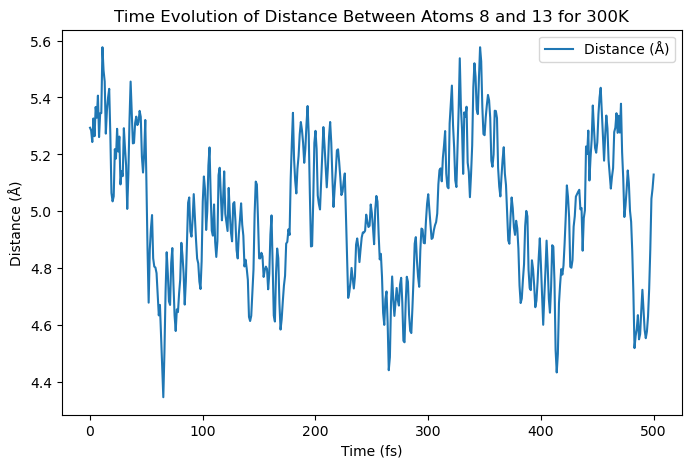

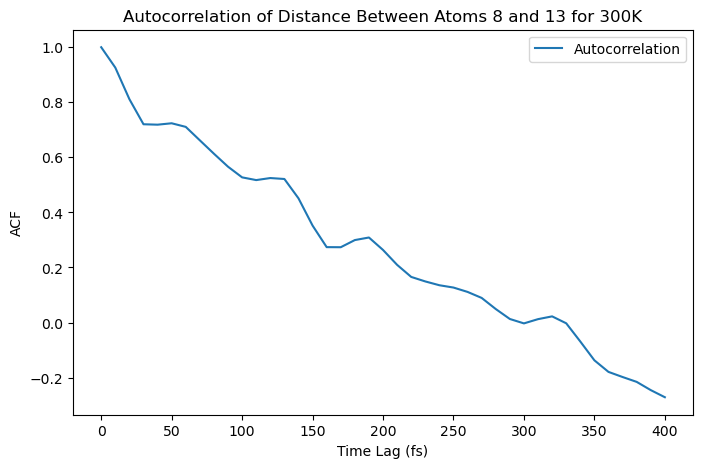

In [100]:
# ---- 📌 PLOTTING TIME EVOLUTION OF DISTANCE ----
plt.figure(figsize=(8, 5))
plt.plot(df_300['distance'], label="Distance (Å)")
plt.xlabel("Time (fs)")
plt.ylabel("Distance (Å)")
plt.title("Time Evolution of Distance Between Atoms 8 and 13 for 300K")
plt.legend()
plt.show()

# ---- 📌 COMPUTE AND PLOT AUTOCORRELATION FUNCTION (ACF) ----
acf_values = acf(df_300['distance'], nlags=40, fft=True)  # Compute ACF with FFT
lags = np.arange(len(acf_values)) * 10  # Convert index to time lag (fs)

plt.figure(figsize=(8, 5))
plt.plot(lags, acf_values, label="Autocorrelation")
plt.xlabel("Time Lag (fs)")
plt.ylabel("ACF")
plt.title("Autocorrelation of Distance Between Atoms 8 and 13 for 300K")
plt.legend()
plt.show()

In [83]:
# --------------------------------- Initial Notes ---------------------------------
'''

We need to:
1. run molecular dynamics of isoprene
2. record the distance between atoms 8 and 13 every 10 steps 
3. plot the time evolution of this distance
4. calculate the autocorrelation function (on what)

Initial Notes

We have the code which currently:
- initialises velocity of molecules and particles
- creates the molecular dynamics object
- have a 'report' function which gets called after a certain number of steps to report
- dynamics.run(100): runs 100 steps of our molecular simulation
- dynamics.attach(report, interval = n): reports every n steps of our simulation
- .get_positions()[k,:] gets the position (in 3-dimensions) of our atoms in our molecules

- we need to investigate the acf function 


- first steps - lets run the dynamics and report every 10 time steps the distance between the two atoms

'''
# --------------------------------- Initial Code ---------------------------------


# this initialises the velocities by drawing from the appropriate distribution at T=500K
MaxwellBoltzmannDistribution(isoprene, temperature_K=500) 

# We now create a molecular dynamics object that can be used to run Langevin dynamics
# the parameters after the structure are the time step, the temperature, and the friction constant (in units of picoseconds)
dynamics = Langevin(isoprene, temperature_K=500, timestep=0.5*units.fs, friction=0.01) 

xyz_file = open('exercise_1_500K.xyz', 'w')

distance_df_500 = []
full_distance_df_500 = []

def report():

    pos_8 = isoprene.get_positions()[8,:] # retrieve position 8
    pos_13 = isoprene.get_positions()[13,:] # retrieve position 13

    distance = pos_8 - pos_13 # find distance (3 dim vector)
    scalar_distance = np.linalg.norm(distance) # norm of distance (1 dim)

    distance_df_500.append(scalar_distance) # add to list of values for plotting
    full_distance_df_500.append(distance) # add to list of values for plotting

    # maybe you don't wanna see this - looks kinda cool tho
    print("Time: {:.3f} fs  |  Potential Energy: {:.3f} eV  |  Kinetic Energy: {:.3f} K | Distance btw. atoms 8 and 13: {:.3f}".format(
        dynamics.get_time()/units.fs, isoprene.get_potential_energy(),
        isoprene.get_kinetic_energy()/(len(isoprene)*(3.0/2.0)*units.kB), 
        scalar_distance))
    
    # writes to the xyz file
    ase.io.write(xyz_file, isoprene, format="extxyz")


dynamics.attach(report, interval = 10)
dynamics.run(5000)

xyzfile.close()
del dynamics

# Convert data into Pandas DataFrame for analysis
df_500 = pd.DataFrame(full_distance_df_500, columns=['dx', 'dy', 'dz'])
df_500['distance'] = distance_df_500

Time: 0.000 fs  |  Potential Energy: -5345.811 eV  |  Kinetic Energy: 535.064 K | Distance btw. atoms 8 and 13: 4.953
Time: 5.000 fs  |  Potential Energy: -5345.776 eV  |  Kinetic Energy: 540.969 K | Distance btw. atoms 8 and 13: 5.097
Time: 10.000 fs  |  Potential Energy: -5345.928 eV  |  Kinetic Energy: 668.358 K | Distance btw. atoms 8 and 13: 5.183
Time: 15.000 fs  |  Potential Energy: -5345.541 eV  |  Kinetic Energy: 476.822 K | Distance btw. atoms 8 and 13: 5.302
Time: 20.000 fs  |  Potential Energy: -5345.633 eV  |  Kinetic Energy: 532.573 K | Distance btw. atoms 8 and 13: 5.253
Time: 25.000 fs  |  Potential Energy: -5345.762 eV  |  Kinetic Energy: 602.603 K | Distance btw. atoms 8 and 13: 5.070
Time: 30.000 fs  |  Potential Energy: -5345.491 eV  |  Kinetic Energy: 470.743 K | Distance btw. atoms 8 and 13: 4.876
Time: 35.000 fs  |  Potential Energy: -5345.745 eV  |  Kinetic Energy: 565.722 K | Distance btw. atoms 8 and 13: 4.807
Time: 40.000 fs  |  Potential Energy: -5345.554 eV

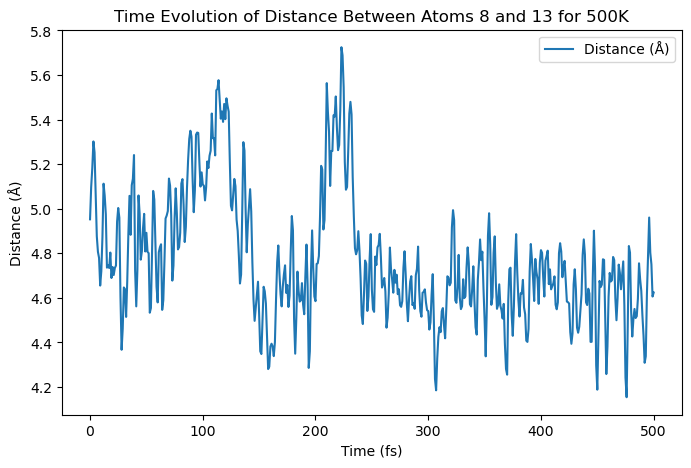

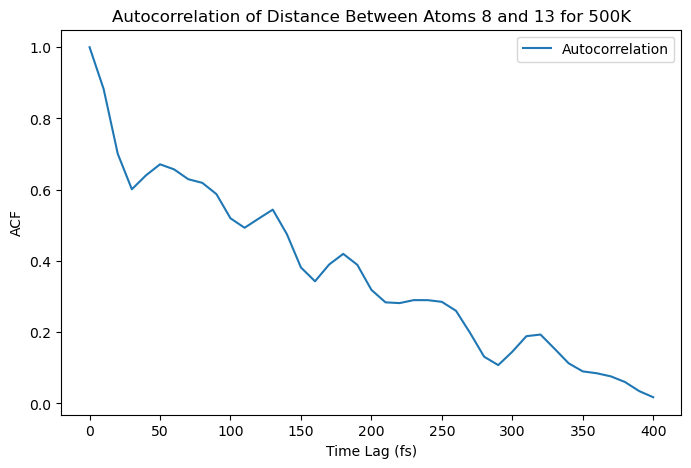

In [101]:
# ---- 📌 PLOTTING TIME EVOLUTION OF DISTANCE ----
plt.figure(figsize=(8, 5))
plt.plot(df_500['distance'], label="Distance (Å)")
plt.xlabel("Time (fs)")
plt.ylabel("Distance (Å)")
plt.title("Time Evolution of Distance Between Atoms 8 and 13 for 500K")
plt.legend()
plt.show()

# ---- 📌 COMPUTE AND PLOT AUTOCORRELATION FUNCTION (ACF) ----
acf_values = acf(df_500['distance'], nlags=40, fft=True)  # Compute ACF with FFT
lags = np.arange(len(acf_values)) * 10  # Convert index to time lag (fs)

plt.figure(figsize=(8, 5))
plt.plot(lags, acf_values, label="Autocorrelation")
plt.xlabel("Time Lag (fs)")
plt.ylabel("ACF")
plt.title("Autocorrelation of Distance Between Atoms 8 and 13 for 500K")
plt.legend()
plt.show()

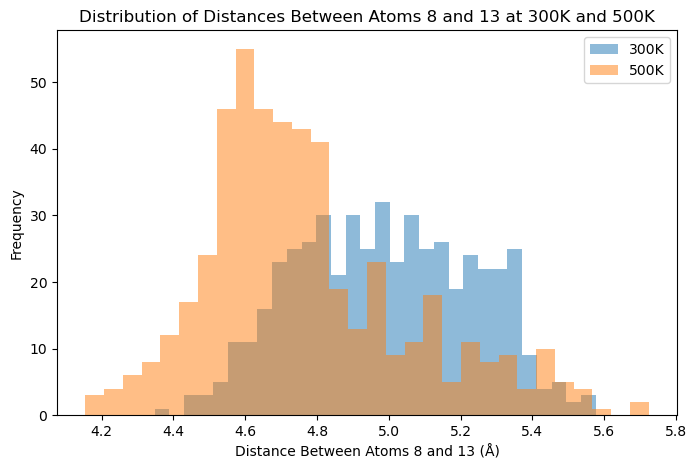

In [105]:
plt.figure(figsize=(8, 5))
plt.hist(df_300['distance'], bins=30, alpha=0.5, label="300K")
plt.hist(df_500['distance'], bins=30, alpha=0.5, label="500K")
plt.xlabel("Distance Between Atoms 8 and 13 (Å)")
plt.ylabel("Frequency")
plt.title("Distribution of Distances Between Atoms 8 and 13 at 300K and 500K")
plt.legend()
plt.show()


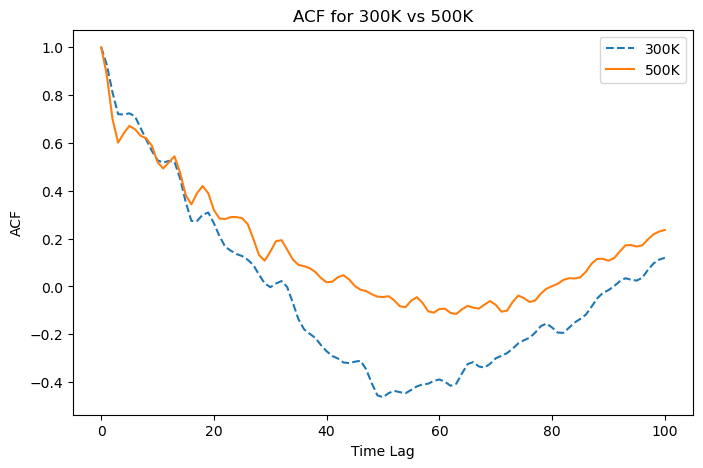

In [103]:
acf_300 = acf(df_300['distance'], nlags=100, fft=True)
acf_500 = acf(df_500['distance'], nlags=100, fft=True)

plt.figure(figsize=(8, 5))
plt.plot(acf_300, label="300K", linestyle="--")
plt.plot(acf_500, label="500K", linestyle="-")
plt.xlabel("Time Lag")
plt.ylabel("ACF")
plt.title("ACF for 300K vs 500K")
plt.legend()
plt.show()


In [104]:
from scipy.optimize import curve_fit

def exp_decay(t, tau):
    return np.exp(-t / tau)

lags = np.arange(len(acf_300)) * 10  # Convert index to time lag in fs

tau_300, _ = curve_fit(exp_decay, lags[:50], acf_300[:50])  # Fit first part of the decay
tau_500, _ = curve_fit(exp_decay, lags[:50], acf_500[:50])  # Fit first part of the decay

print(f"Correlation Time 300K: {tau_300[0]:.2f} fs")
print(f"Correlation Time 500K: {tau_500[0]:.2f} fs")


Correlation Time 300K: 117.89 fs
Correlation Time 500K: 160.67 fs


Polyisoprene
---

In [54]:
# we now create a polyisoprene molecule
polyisoprene = pubchem_atoms_search(smiles="CC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)C")
view(polyisoprene, viewer='x3d')

/Users/mac/anaconda3/lib/python3.11/site-packages/ase/data/pubchem.py:80: UserWarning: The structure "CC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)C" has more than one conformer in PubChem. By default, the first conformer is returned, please ensure you are using the structure you intend to or use the `ase.data.pubchem.pubchem_conformer_search` function
  warnings.warn(


Main Task
---
Create a moleculary dynamics simulation in which you stretch the molecule very slowly, and measure the restoring force as a function
of displacement (I suggest using method 2 from above). 
Notes: 
- You are  interested in the force _between_ the two molecules held fixed (i.e. the force difference) and only in the component of the force along
the line connecting the two fixed atoms. 
- It is enough to record the structure every 100 steps or so, and be prepared to run the simulation for 100,000 steps or more for each fixed distance.
- I recommend that you create and record the trajectory first, and the analyse it afterwards, because the main computational cost is creating the trajectory. 
- When analysing the data, do not include data immediately after each stretch, allow the system to relax towards the equilibrium distribution for a few
thousand steps before collecting the force data.
- Calculate the autocorrelation of the restoring force value and use it to compute error bars on your measurement

Optional extension
---

The fact that the restoring force is entropic in origin has implications for the temperature dependence of the restoring force. Repeat the main task for
different temperature settings of the Langevin dynamics, and compare the results!